# Fine-Tuning Dataset Creation

This notebook processes a source JSON file containing German texts classified by CEFR level. It then uses a generative Large Language Model (LLM) to create synthetic variations of these texts, rewriting them to different CEFR levels to build a comprehensive fine-tuning dataset

**Pipeline Overview:**
1. Initialize Environment: Install and import necessary Python packages.
2. Authenticate: Set up Google Cloud credentials for using the VertexAI API.
3. Load and Preprocess: Load the source JSON data and simplify its structure for processing.
4. Analyze Source Data: Perform a quick analysis to understand the distribution of texts across CEFR levels.
5. Configure Generative Model: Set up the VertexAI Gemini model and create a robust prompt for the text rewriting task.
6. Generate Synthetic Data: Loop through the source texts and use the LLM to generate new versions at different target CEFR levels.
7. Analyze and Save: Analyze the final generated dataset for quality and distribution, then save it to a JSON file.

# 1. Install and Import Packages

In [ ]:
# Install packages
!pip install -q langchain_google_vertexai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 1.1 MB/s eta 0:00:00


In [ ]:
# Imports
import json, time, vertexai, os, re, random
from collections import Counter
from langchain_google_vertexai import VertexAI
from google.colab import auth
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Authentication and Google Cloud Setup

In [ ]:
# Set the project ID for Google Cloud Project
project_ID = userdata.get('gcloud-project')

# Authenticate user and set up application default credentials
!gcloud auth application-default login

# Set the active project for the gcloud command-line tool
!gcloud config set project {project_ID}
os.environ["GCLOUD_PROJECT"] = project_ID

# Run the standard Colab auth for full integration
auth.authenticate_user(project_id=project_ID)

# Link the credentials to your project for billing and quota
!gcloud auth application-default set-quota-project {project_ID}

Go to the following link in your browser, and complete the sign-in prompts:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fapplicationdefaultauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login&state=pyupKVsvLfZAQyIKrXPLbk8ELixTI0&prompt=consent&token_usage=remote&access_type=offline&code_challenge=_aYdAxn-xZObyQ6MkaO4JtZFphrDBpXLDqZ0U0ZJ-yI&code_challenge_method=S256

Once finished, enter the verification code provided in your browser: 4/0AVMBsJhnOzsRfoKaJMP_7De2REoK8iLMFjK6PfoEv9fVOjf-jYFOHRul7_4wWk2n4chcxA

Credentials saved to file: [/content/.config/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).
Ca

# 3. Source Data Loading and Preprocessing

In [ ]:
input_file = '/content/elg-cefr-de.json'

# Open file
try:
    with open(input_file, 'r', encoding='utf-8') as f:
        data = json.load(f)

        # Loop through the first few JSON objects and print them
        for i, record in enumerate(data[:3]):
            print(json.dumps(record, ensure_ascii=False, indent=2))

except FileNotFoundError:
    print(f"File '{input_file}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")

{
  "title": "na",
  "lang": "de",
  "source_name": "elg-cefr-de",
  "format": "document-level",
  "category": "reference",
  "cefr_level": "B1",
  "license": "CC BY-NC-SA 4.0",
  "text": "Wie es Monika in Dresden geht? Ganz genau weiß ich das nicht. Ich habe sie seit dem Umzug nicht mehr gesehen. Natürlich habe ich ihr schon ein paar Mails geschrieben. Aber bisher hat sie noch nicht geantwortet. Ich nehme an, dass sie noch viel mit dem Umzug und der Arbeitssuche zu tun hat. Und wahrscheinlich entdeckt sie viel Interessantes in der Stadt. Sie fängt ein neues Leben an, und sicherlich ist das alles sehr spannend für sie. Bestimmt geht sie oft aus, um neue Leute kennenzulernen. Ich könnte mir vorstellen, dass sie jetzt in den ersten Wochen schon ein paar neue Freunde gefunden hat. Ich weiß nicht genau, wie sie das macht, aber irgendwie hat sie immer viele lustige, interessante, nette Leute um sich. Allerdings sind alte Freunde, die man schon lange kennt, auch sehr wichtig. Ich vermute mal

In [ ]:
output_file = 'processed_dataset.json'

# Keep only desired data from each JSON object and save to a new JSON file
try:
    # Create a new list to hold the processed records
    processed_list = []

    # Loop through each record, extract the data and add it to the list
    for item in data:
        extracted_data = {
            'cefr_level': item.get('cefr_level'),
            'text': item.get('text')
        }
        processed_list.append(extracted_data)

    # Write list to the new JSON file
    with open(output_file, 'w', encoding='utf-8') as outfile:
        json.dump(processed_list, outfile, ensure_ascii=False, indent=2)

    print(f"{len(processed_list)} records were processed.")

except Exception as e:
    print(f"An error occurred: {e}")

   1542 records were processed.


In [ ]:
# Explore preprocessed dataset
try:
    with open(output_file, 'r', encoding='UTF-8') as f:
        data = json.load(f)

        # Loop through the first 3 JSON blocks and print them
        for i, record in enumerate(data[:3]):
            print(json.dumps(record, ensure_ascii=False, indent=2))

except Exception as e:
    print(f"An error occurred: {e}")

{
  "cefr_level": "B1",
  "text": "Wie es Monika in Dresden geht? Ganz genau weiß ich das nicht. Ich habe sie seit dem Umzug nicht mehr gesehen. Natürlich habe ich ihr schon ein paar Mails geschrieben. Aber bisher hat sie noch nicht geantwortet. Ich nehme an, dass sie noch viel mit dem Umzug und der Arbeitssuche zu tun hat. Und wahrscheinlich entdeckt sie viel Interessantes in der Stadt. Sie fängt ein neues Leben an, und sicherlich ist das alles sehr spannend für sie. Bestimmt geht sie oft aus, um neue Leute kennenzulernen. Ich könnte mir vorstellen, dass sie jetzt in den ersten Wochen schon ein paar neue Freunde gefunden hat. Ich weiß nicht genau, wie sie das macht, aber irgendwie hat sie immer viele lustige, interessante, nette Leute um sich. Allerdings sind alte Freunde, die man schon lange kennt, auch sehr wichtig. Ich vermute mal, dass es ihr gut geht, sie mich aber bestimmt auch vermisst."
}
{
  "cefr_level": "B1",
  "text": "Ich habe schon als Kind davon geträumt, später auf ein

# 4. Initial Dataset Analysis

In [ ]:
try:
    with open(output_file, 'r', encoding='UTF-8') as f:
        data_list = json.load(f)

    # Extract all the 'cefr_level' values from the file
    levels = [record.get('cefr_level') for record in data_list]

    # Count the occurrences of each level
    level_counts = Counter(levels)

    # Print the count for each level found in the file
    for level, count in sorted(level_counts.items()):
        print(f"Level {level}: {count} records")

except Exception as e:
    print(f"An error occurred: {e}")

Level A1: 88 records
Level A2: 396 records
Level B1: 421 records
Level B2: 408 records
Level C1: 130 records
Level C2: 99 records


# 5. Generative Model Configuration

This section configures the connection to the Vertex AI Gemini model

In [ ]:
# If number of examples for a level must be limited, change here
# Currently, all examples are being used
# A1, A2 and C2 examples are not used for this project
B1_limit = 421
B2_limit = 408
C1_limit = 130

input_file = 'processed_dataset.json'
output_file = 'fine-tuning-dataset.json'

# Initialize the Vertex AI model for generation
vertexai.init(project=project_ID, location="europe-central2")

llm = VertexAI(
    model_name="gemini-2.5-flash-lite",
    max_output_tokens=9000,
    temperature=0.4, # A moderately creative temperature for rewriting
    top_p=0.8
)

def create_generation_prompt(original_text, original_level, target_level):
    """Creates a structured prompt to rewrite text to a new CEFR level"""
    return f"""
    You are an expert German language teacher and content editor specializing in CEFR levels.
    Your task is to rewrite a German text from its original CEFR level to a new target level.

    **Instructions:**
    1.  Read the original text and its CEFR level.
    2.  Rewrite the entire text to perfectly match the **target CEFR level ({target_level})**.
    3.  Create a brief, clear explanation of the top 2-3 most important changes you made. **The explanation must also be in German!**

    **Original Text (Level: {original_level}):**
    '{original_text}'

    **Output ONLY a single, valid JSON object with two keys:**
    - 'rewritten_text': The full text rewritten for the {target_level} level.
    - 'explanation': The brief explanation of your changes.

    Do not include any other text or formatting like markdown backticks. Your entire response must be the raw JSON object.
    """

def generate_version(text, original_level, target_level):
    """Calls the LLM and extracts the JSON from the response"""
    try:
        prompt = create_generation_prompt(text, original_level, target_level)
        response_str = llm.invoke(prompt)

        # This regex finds the first '{' and the last '}' and extracts everything in between
        # This way, we avoid the script not finding the JSON and raising an error
        json_match = re.search(r'\{.*\}', response_str, re.DOTALL)

        if json_match:  # If a match (JSON block) is found
            clean_json_str = json_match.group(0)
            return json.loads(clean_json_str)
        else:  # If no JSON block is found at all, log it and skip.
            print(f"No JSON object found in the LLM response. Skipping")
            return None

    except json.JSONDecodeError:  # If an error happens
        print(f"Could not parse the extracted JSON. Skipping")
        return None
    except Exception as e:
        print(f"Error during LLM call: {e}. Skipping.")
        return None

# 6. Synthetic Data Generation

The script iterates through the texts from the B1, B2 and C1 levels and uses the configured LLM to generate two new versions for each source text

In [ ]:
# Create synthetic data
# Separate texts by CEFR level
texts_by_level = {
    'B1': [item for item in data_list if item.get('cefr_level') == 'B1'],
    'B2': [item for item in data_list if item.get('cefr_level') == 'B2'],
    'C1': [item for item in data_list if item.get('cefr_level') == 'C1'],
}

fine_tuning_dataset = []
processed_count = 0

# Process B1 texts: Generate B2 and C1
for item in texts_by_level['B1'][:B1_limit]:
    processed_count += 1
    print(f"({processed_count}) Processing B1 text")
    # B1 -> B2
    b2_version = generate_version(item['text'], 'B1', 'B2')
    # Check that both required keys are in the response
    if b2_version and 'rewritten_text' in b2_version and 'explanation' in b2_version:
        fine_tuning_dataset.append({"instruction": "Schreibe den folgenden deutschen Text von seinem ursprünglichen GER-Niveau (B1) auf das Zielniveau (B2) um.", "input": item['text'], "output": b2_version['rewritten_text'], "explanation": b2_version['explanation']})
    time.sleep(1)
    # B1 -> C1
    c1_version = generate_version(item['text'], 'B1', 'C1')
    # Check that both required keys are in the response
    if c1_version and 'rewritten_text' in c1_version and 'explanation' in c1_version:
        fine_tuning_dataset.append({"instruction": "Schreibe den folgenden deutschen Text von seinem ursprünglichen GER-Niveau (B1) auf das Zielniveau (C1) um.", "input": item['text'], "output": c1_version['rewritten_text'], "explanation": c1_version['explanation']})
    time.sleep(1)

# Process B2 texts: Generate B1 and C1
for item in texts_by_level['B2'][:B2_limit]:
    processed_count += 1
    print(f"({processed_count}) Processing B2 text")
    # B2 -> B1
    b1_version = generate_version(item['text'], 'B2', 'B1')
    # Check that both required keys are in the response
    if b1_version and 'rewritten_text' in b1_version and 'explanation' in b1_version:
        fine_tuning_dataset.append({"instruction": "Schreibe den folgenden deutschen Text von seinem ursprünglichen GER-Niveau (B2) auf das Zielniveau (B1) um.", "input": item['text'], "output": b1_version['rewritten_text'], "explanation": b1_version['explanation']})
    time.sleep(1)
    # B2 -> C1
    c1_version = generate_version(item['text'], 'B2', 'C1')
    # Check that both required keys are in the response
    if c1_version and 'rewritten_text' in c1_version and 'explanation' in c1_version:
        fine_tuning_dataset.append({"instruction": "Schreibe den folgenden deutschen Text von seinem ursprünglichen GER-Niveau (B2) auf das Zielniveau (C1) um.", "input": item['text'], "output": c1_version['rewritten_text'], "explanation": c1_version['explanation']})
    time.sleep(1)

# Process C1 texts: Generate B1 and B2
for item in texts_by_level['C1'][:C1_limit]:
    processed_count += 1
    print(f"({processed_count}) Processing C1 text")
    # C1 -> B1
    b1_version = generate_version(item['text'], 'C1', 'B1')
    # Check that both required keys are in the response
    if b1_version and 'rewritten_text' in b1_version and 'explanation' in b1_version:
        fine_tuning_dataset.append({"instruction": "Schreibe den folgenden deutschen Text von seinem ursprünglichen GER-Niveau (C1) auf das Zielniveau (B1) um.", "input": item['text'], "output": b1_version['rewritten_text'], "explanation": b1_version['explanation']})
    time.sleep(1)
    # C1 -> B2
    b2_version = generate_version(item['text'], 'C1', 'B2')
    # Check that both required keys are in the response
    if b2_version and 'rewritten_text' in b2_version and 'explanation' in b2_version:
        fine_tuning_dataset.append({"instruction": "Schreibe den folgenden deutschen Text von seinem ursprünglichen GER-Niveau (C1) auf das Zielniveau (B2) um.", "input": item['text'], "output": b2_version['rewritten_text'], "explanation": b2_version['explanation']})
    time.sleep(1)

# Save the final combined dataset
print(f"\nGeneration complete. Total examples for fine-tuning: {len(fine_tuning_dataset)}")
with open(output_file, 'w', encoding='UTF-8') as f:
    json.dump(fine_tuning_dataset, f, ensure_ascii=False, indent=2)

print(f"Successfully saved to '{output_file}'")

(1) Processing B1 text
(2) Processing B1 text
(3) Processing B1 text
(4) Processing B1 text
(5) Processing B1 text
(6) Processing B1 text
(7) Processing B1 text
(8) Processing B1 text
(9) Processing B1 text
(10) Processing B1 text
(11) Processing B1 text
(12) Processing B1 text
(13) Processing B1 text
(14) Processing B1 text
(15) Processing B1 text
(16) Processing B1 text
(17) Processing B1 text
(18) Processing B1 text
(19) Processing B1 text
(20) Processing B1 text
(21) Processing B1 text
(22) Processing B1 text
(23) Processing B1 text
(24) Processing B1 text
(25) Processing B1 text
(26) Processing B1 text
(27) Processing B1 text
(28) Processing B1 text
(29) Processing B1 text
(30) Processing B1 text
(31) Processing B1 text
(32) Processing B1 text
(33) Processing B1 text
(34) Processing B1 text
(35) Processing B1 text
(36) Processing B1 text
(37) Processing B1 text
(38) Processing B1 text
(39) Processing B1 text
(40) Processing B1 text
(41) Processing B1 text
(42) Processing B1 text
(

# 7. Final Dataset Analysis and Visualization

Total number of examples: 1895

Distribution of Transformation Tasks:
instruction
Schreibe den folgenden deutschen Text von seinem ursprünglichen GER-Niveau (B1) auf das Zielniveau (B2) um.    417
Schreibe den folgenden deutschen Text von seinem ursprünglichen GER-Niveau (B1) auf das Zielniveau (C1) um.    413
Schreibe den folgenden deutschen Text von seinem ursprünglichen GER-Niveau (B2) auf das Zielniveau (B1) um.    406
Schreibe den folgenden deutschen Text von seinem ursprünglichen GER-Niveau (B2) auf das Zielniveau (C1) um.    400
Schreibe den folgenden deutschen Text von seinem ursprünglichen GER-Niveau (C1) auf das Zielniveau (B2) um.    130
Schreibe den folgenden deutschen Text von seinem ursprünglichen GER-Niveau (C1) auf das Zielniveau (B1) um.    129
Name: count, dtype: int64

Text length analysis (in characters)

Input Text Length Stats:
count    1895.000000
mean      983.460158
std       360.741198
min       180.000000
25%       746.000000
50%       958.000000
75%      122

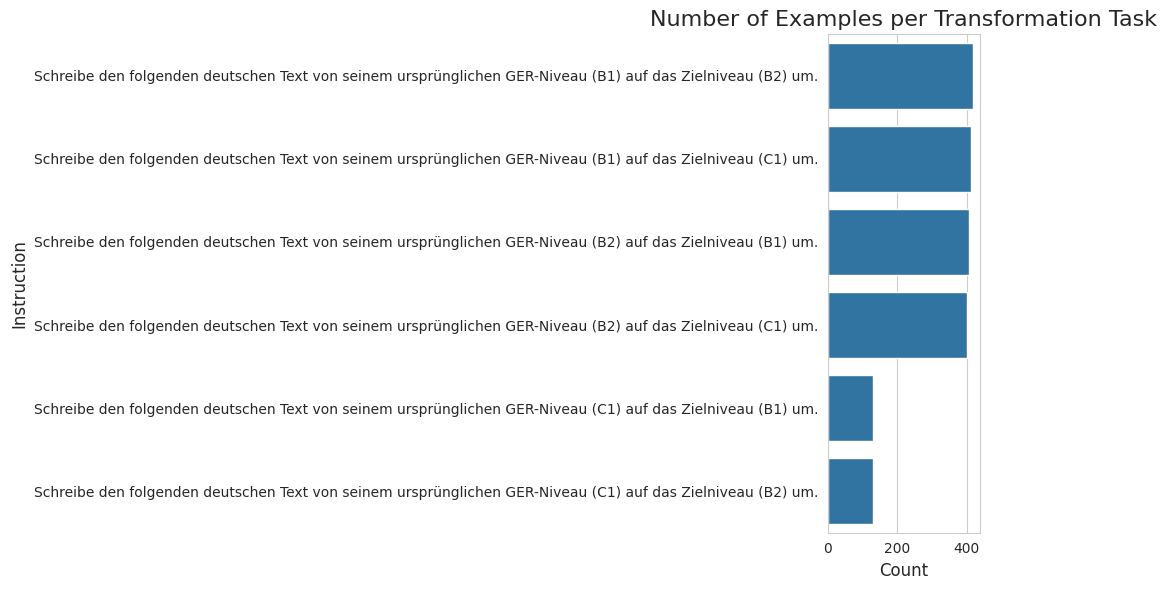

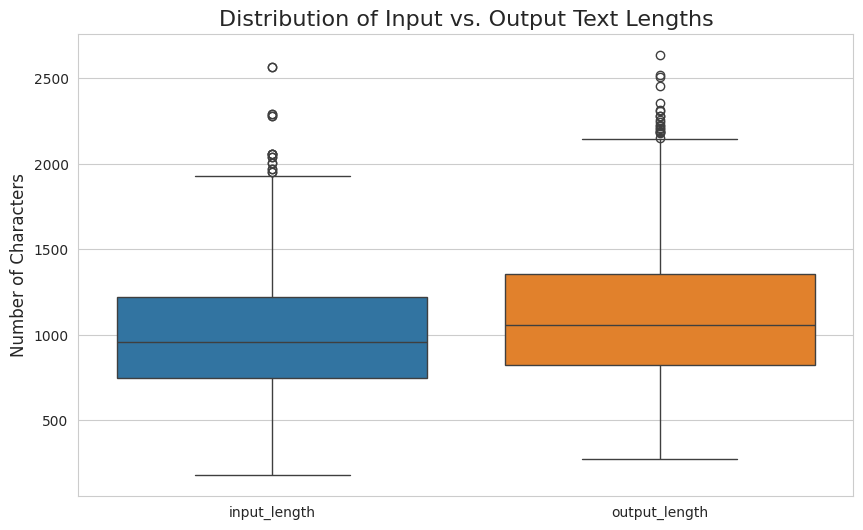


Example 1
Instruction: Schreibe den folgenden deutschen Text von seinem ursprünglichen GER-Niveau (B2) auf das Zielniveau (B1) um.
Input: Reaktion auf eine Werbeanzeige
Maria Schmidt
Zentralplatz 1
1234 Stadt X
Schweiz (II)
AUPAIRSGLOBAL
Bahnhofstr. 101
65185 Wiesbaden                    Stadt Y, 21.10.2011
Fragen über eine Au-pair-Stel...
Output: Antwort auf eine Anzeige
Maria Schmidt
Zentralplatz 1
1234 Stadt X
Schweiz
AUPAIRSGLOBAL
Bahnhofstr. 101
65185 Wiesbaden
Stadt Y, 21.10.2011
Fragen zur Au-pair-Stelle in Deutschland
Sehr geehrte Damen...
Explanation: 1. Vereinfachung des Satzbaus: Komplexe Satzgefüge (z.B. mit Nebensätzen, die durch 'deshalb' oder 'weil' eingeleitet werden) wurden durch einfachere Sätze ersetzt.
2. Wortschatzanpassung: Schwierigere Wörter und Ausdrücke (z.B. 'Aufenthaltsformalitäten', 'kummern', 'im Vorauf') wurden durch gebräuchlichere B1-Wörter ersetzt (z.B. 'Regeln', 'kümmern', 'Hilfe').
3. Grammatische Korrekturen: Kleinere Fehler (z.B. 'ein anderer Frag

In [ ]:
finetuning_file = 'fine-tuning-dataset.json'

try:
    # Load the dataset into a pandas DataFrame
    with open(finetuning_file, 'r', encoding='UTF-8') as f:
        data = json.load(f)
    df = pd.DataFrame(data)  # Create DataFrame

    # Statistics
    print(f"Total number of examples: {len(df)}")

    # Analyze the instruction field to see the distribution of tasks
    print("\nDistribution of Transformation Tasks:")
    print(df['instruction'].value_counts())

    # Text Length Analysis
    print("\nText length analysis (in characters)")
    df['input_length'] = df['input'].str.len()
    df['output_length'] = df['output'].str.len()

    print("\nInput Text Length Stats:")
    print(df['input_length'].describe())

    print("\nOutput Text Length Stats:")
    print(df['output_length'].describe())

    # Visualization
    # Set plot style
    sns.set_style("whitegrid")

    # Plot 1: Bar chart of instruction distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(y=df['instruction'])
    plt.title('Number of Examples per Transformation Task', fontsize=16)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel('Instruction', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Plot 2: Box plot of text lengths
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df[['input_length', 'output_length']])
    plt.title('Distribution of Input vs. Output Text Lengths', fontsize=16)
    plt.ylabel('Number of Characters', fontsize=12)
    plt.show()

    # Random examples
    # Display 2 random examples from the dataset
    for i, sample in enumerate(df.sample(n=2).to_dict(orient='records')):
        print(f"\nExample {i+1}")
        print(f"Instruction: {sample['instruction']}")
        print(f"Input: {sample['input'][:200]}...")  # Show first 200 chars
        print(f"Output: {sample['output'][:200]}...")  # Show first 200 chars
        print(f"Explanation: {sample['explanation']}")

except Exception as e:
    print(f"An error occurred: {e}")